Start on model here, what exactly are we modeling?

Equipment types are all features?
    And therefore we want to predict success
        what success criterion (placing?)
        
        
    Differences in success values among men and women???
        can we draw conclusions about equipment use based on comparing win differences in men and women
        
        
        
Add in things about weight as well??

when doing age what are our predictors??

What do we actually want from this 


wilks coefficient 


Try and predict wilks coefficent on equipment usage and wieght??
    how does the wilks implement equipment use?
    
    
    does it increase wilks, and does it do it enough to increase performance 
    


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt_kwargs = {'figsize': (10, 6)} 

In [7]:
powerlifting = pd.read_csv("openpowerlifting.csv")
powerlifting.drop(labels=['Squat4Kg','Bench4Kg','Deadlift4Kg','Age'],axis=1,inplace=True)
powerlifting.dropna(inplace=True)

powerlifting = powerlifting[(powerlifting['Place']!='DQ') & (powerlifting['Place']!='G')]
powerlifting['Place'] = powerlifting['Place'].apply(lambda x: int(x))
powerlifting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269576 entries, 0 to 386383
Data columns (total 13 columns):
MeetID            269576 non-null int64
Name              269576 non-null object
Sex               269576 non-null object
Equipment         269576 non-null object
Division          269576 non-null object
BodyweightKg      269576 non-null float64
WeightClassKg     269576 non-null object
BestSquatKg       269576 non-null float64
BestBenchKg       269576 non-null float64
BestDeadliftKg    269576 non-null float64
TotalKg           269576 non-null float64
Place             269576 non-null int64
Wilks             269576 non-null float64
dtypes: float64(6), int64(2), object(5)
memory usage: 28.8+ MB


In [8]:
powerlifting = powerlifting[powerlifting['BestSquatKg']>0]

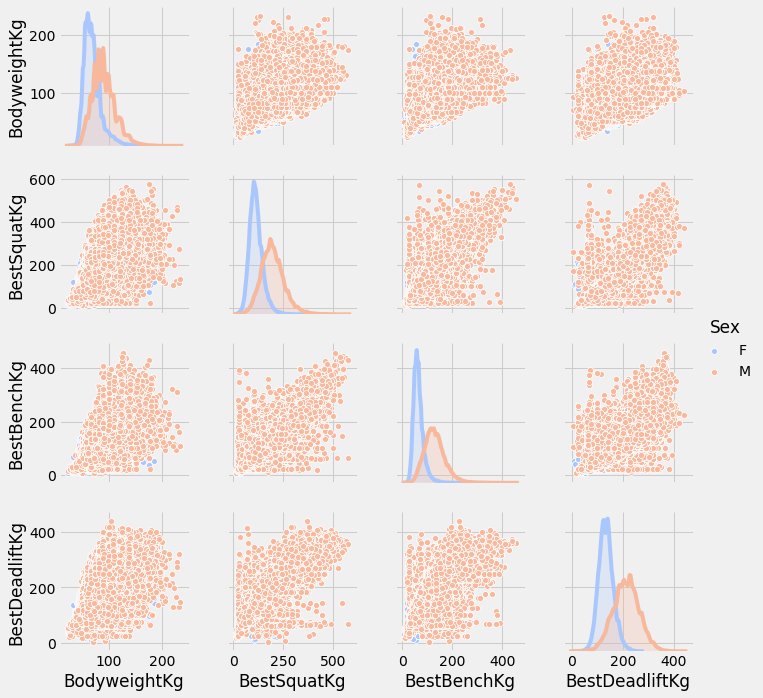

In [10]:
sns.pairplot(powerlifting, vars=['BodyweightKg','BestSquatKg','BestBenchKg',
                            'BestDeadliftKg'],hue='Sex',palette='coolwarm')

In [20]:
def change_place(val):
    if val > 1:
        return 0
    else:
        return 1

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [107]:
#Creating another DataFrame, that will be used in the predictions
df_prov = pd.DataFrame.copy(powerlifting)
#Removing object columns that will not be used
df_prov.drop(labels=['MeetID','Name','Division','WeightClassKg','Equipment','TotalKg'],axis=1,inplace=True)

In [108]:
cat_feats = ['Sex']
df_predict = pd.get_dummies(df_prov,columns=cat_feats,drop_first=True)

In [109]:
df_predict['Place']=df_predict['Place'].apply(change_place)
df_predict.head()

,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,Place,Wilks,Sex_M
0,59.60,47.63,20.41,70.31,1,155.05,0
1,58.51,142.88,95.25,163.29,1,456.38,0
2,58.51,142.88,95.25,163.29,1,456.38,0
5,62.41,170.10,77.11,145.15,1,424.40,0
6,67.31,124.74,95.25,163.29,1,391.98,0


In [110]:
X_train, X_test, y_train, y_test = train_test_split(df_predict.drop('Place',axis=1), df_predict['Place'],test_size=0.3)

In [111]:
rfc = RandomForestClassifier()

In [112]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [113]:
pred_rfc = rfc.predict(X_test)


In [114]:
print('Classification report for Random Forest:')
print(classification_report(y_test,pred_rfc))

Classification report for Random Forest:
             precision    recall  f1-score   support

          0       0.60      0.67      0.63     41537
          1       0.61      0.54      0.57     39336

avg / total       0.60      0.60      0.60     80873



In [166]:
exp_df = pd.DataFrame.copy(powerlifting)

exp_df['equipment_wraps'] = exp_df.Equipment.map({'Wraps': 1,'Raw':0,'Single-ply':0,'Multi-ply':0,'Straps':0})
exp_df['equipment_raw'] = exp_df.Equipment.map({'Wraps': 0,'Raw':1,'Single-ply':0,'Multi-ply':0,'Straps':0})
exp_df['equipment_multi'] = exp_df.Equipment.map({'Wraps': 0,'Raw':0,'Single-ply':0,'Multi-ply':1,'Straps':0})
exp_df['equipment_straps'] = exp_df.Equipment.map({'Wraps': 0,'Raw':0,'Single-ply':0,'Multi-ply':0,'Straps':1})
exp_df['equipment_single'] = exp_df.Equipment.map({'Wraps': 0,'Raw':0,'Single-ply':1,'Multi-ply':0,'Straps':0})

equipment_wraps = exp_df.query("equipment_wraps == '1'")
wraps_mean = equipment_wraps['TotalKg'].mean()

equipment_raw = exp_df.query("equipment_raw =='1'")
raw_mean = equipment_raw['TotalKg'].mean()

equipment_single = exp_df.query("equipment_single == '1'")
single_mean = equipment_single['TotalKg'].mean()

equipment_multi = exp_df.query("equipment_multi == '1'")
multi_mean = equipment_multi['TotalKg'].mean()

equipment_straps = exp_df.query("equipment_straps =='1'")
straps_mean = equipment_straps['TotalKg'].mean()

totalkg_means = {'means':[wraps_mean,raw_mean,single_mean,multi_mean,straps_mean],'labels':['wraps','raw','single-ply','multi-ply','straps']}

In [167]:
#Split Men and women
#Variable Limiting to men
liftsM = exp_df.query("Sex == 'M'")
liftsM.dropna(inplace=True)

liftsM_noequip = powerlifting.query("Sex == 'M'")




#Variable Limiting to women
liftsF = exp_df.query("Sex == 'F'")
liftsF.dropna(inplace=True)


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [168]:
liftsM.drop(labels=['MeetID','Name','Division','WeightClassKg','Equipment','Wilks'],axis=1,inplace=True)


c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [169]:
cat_feats = ['Sex']
df_predict = pd.get_dummies(liftsM,columns=cat_feats,drop_first=True)

In [170]:
df_predict['Place']=df_predict['Place'].apply(change_place)
df_predict.head()

,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,equipment_wraps,equipment_raw,equipment_multi,equipment_straps,equipment_single
23,71.94,154.22,115.67,183.70,453.59,0,0,1,0,0,0
24,70.67,163.29,111.13,204.12,478.54,1,0,1,0,0,0
27,71.30,181.44,99.79,188.24,469.47,1,1,0,0,0,0
28,79.65,161.03,127.01,197.31,485.35,0,0,1,0,0,0
29,80.10,190.51,120.20,231.33,542.04,1,0,1,0,0,0


In [171]:
X_train, X_test, y_train, y_test = train_test_split(df_predict.drop('Place',axis=1), df_predict['Place'],test_size=0.3)

In [172]:
rfc = RandomForestClassifier()

In [173]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [174]:
pred_rfc = rfc.predict(X_test)

In [175]:
print('Classification report for Random Forest:')
print(classification_report(y_test,pred_rfc))

Classification report for Random Forest:
             precision    recall  f1-score   support

          0       0.66      0.73      0.69     33863
          1       0.62      0.54      0.57     27604

avg / total       0.64      0.64      0.64     61467



In [176]:
rfc.score(X_test, y_test)

0.6419379504449542

In [177]:
# Create experimental dataframes for each equipment type
exp1_rawM = liftsM[(liftsM['Equipment']=='Raw')].copy()

exp1_singleM = liftsM[(liftsM['Equipment']=='Single-ply')].copy()

exp1_wrapsM = liftsM[(liftsM['Equipment']=='Wraps')].copy()

exp1_multiM = liftsM[(exp_df['Equipment']=='Multi-ply')].copy()

exp1_rawF = liftsF[(liftsF['Equipment']=='Raw')].copy()

exp1_singleF = liftsF[(liftsF['Equipment']=='Single-ply')].copy()

exp1_wrapsF = liftsF[(liftsF['Equipment']=='Wraps')].copy()

exp1_multiF = liftsF[(liftsF['Equipment']=='Multi-ply')].copy()

KeyError: 'Equipment'

In [178]:
from sklearn.metrics import mean_squared_error
rfc_mse = mean_squared_error(pred_rfc, y_test)


In [179]:
rfc_mse

0.3580620495550458

In [180]:
import math

In [181]:
math.sqrt(rfc_mse)

0.59838286201649

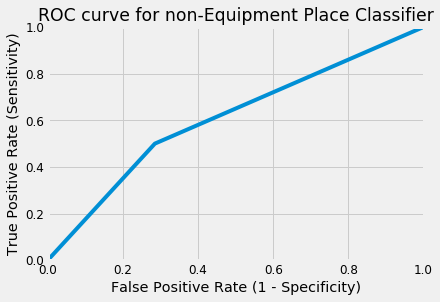

In [162]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_rfc)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for non-Equipment Place Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [122]:
liftsM.drop(labels=['MeetID','Name','Division','WeightClassKg','Equipment','Wilks'],axis=1,inplace=True)

In [124]:
cat_feats = ['Sex']
df_predict = pd.get_dummies(liftsM,columns=cat_feats,drop_first=True)
df_predict['Place']=df_predict['Place'].apply(change_place)
df_predict.head()

,BodyweightKg,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg,Place,equipment_wraps,equipment_raw,equipment_multi,equipment_straps,equipment_single
23,71.94,154.22,115.67,183.70,453.59,0,0,1,0,0,0
24,70.67,163.29,111.13,204.12,478.54,1,0,1,0,0,0
27,71.30,181.44,99.79,188.24,469.47,1,1,0,0,0,0
28,79.65,161.03,127.01,197.31,485.35,0,0,1,0,0,0
29,80.10,190.51,120.20,231.33,542.04,1,0,1,0,0,0


In [125]:
X_train, X_test, y_train, y_test = train_test_split(df_predict.drop('Place',axis=1), df_predict['Place'],test_size=0.3)

In [126]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [127]:
pred_rfc = rfc.predict(X_test)

In [128]:
print('Classification report for Random Forest:')
print(classification_report(y_test,pred_rfc))

Classification report for Random Forest:
             precision    recall  f1-score   support

          0       0.66      0.72      0.69     33760
          1       0.62      0.54      0.58     27707

avg / total       0.64      0.64      0.64     61467



In [129]:
rfc_mse = mean_squared_error(pred_rfc, y_test)
rfc_mse

0.35881041859859764

In [130]:
math.sqrt(rfc_mse)

0.5990078618837966

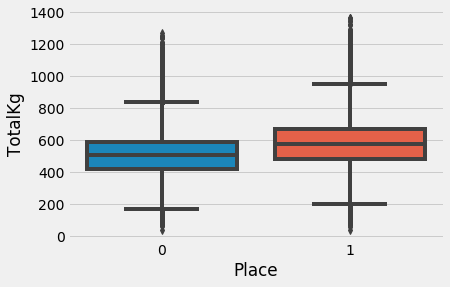

In [131]:
sns.boxplot(x='Place',y='TotalKg',data=df_predict)

In [145]:
from sklearn.metrics import roc_curve
from sklearn import metrics

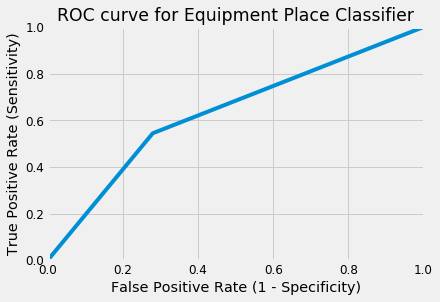

In [147]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_rfc)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Equipment Place Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [163]:
from sklearn.model_selection import cross_val_score

In [164]:
scores = cross_val_score(rfc, df_predict.drop('Place',axis=1), df_predict['Place'], cv=10)

In [183]:
scores.mean()

0.5883870138313732

In [182]:
scores = cross_val_score(rfc, df_predict.drop('Place',axis=1), df_predict['Place'], cv=10)